In [2]:
import pandas as pd
import numpy as np

# Visualization library
import altair as alt
alt.data_transformers.enable('default', max_rows=None)

# Dates management
import datetime

# For the computation of Kaplan-Meier estimates and log-rank tests
import lifelines

<a id="data_exploration"></a>
# 1. Data Exploration

The dataset is available in the */data* folder. The database structure is freely inspired from the AP-HP Clinical Data Warehouse (CDW).


<a id="patient_ids"></a>
## 1.1 Patients' identities and demographic data

In [10]:
df_person = pd.read_pickle('data/df_person.pkl')
df_person.info()
df_person.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16168 entries, 0 to 216
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   birth_datetime       16168 non-null  datetime64[ns]
 1   death_datetime       8848 non-null   datetime64[ns]
 2   gender_source_value  16168 non-null  object        
 3   cdm_source           16168 non-null  object        
 4   person_id            16168 non-null  object        
dtypes: datetime64[ns](2), object(3)
memory usage: 757.9+ KB


,birth_datetime,death_datetime,gender_source_value,cdm_source,person_id
0,2016-08-02,2024-06-17,female,EHR 1,86484326
1,2013-11-01,2022-01-23,female,EHR 1,89213495
2,2013-04-02,2022-02-27,f,EHR 1,88207887
3,2016-08-19,2021-09-24,f,EHR 1,80499395
4,2022-06-04,2022-11-01,f,EHR 1,84190053


In [5]:
print(f"We have {df_person.person_id.nunique()} unique patient ids in this dataset.")

We have 16168 unique patient ids in this dataset.


In [11]:
print(f"The available gender values are the following : {df_person.gender_source_value.unique()}")

The available gender values are the following : ['female' 'f' 'male' 'm']


<a id="visits"></a>
## 1.2 Administrative data related to patients' pathways

In [6]:
df_visit = pd.read_pickle('data/df_visit.pkl')
df_visit.info()
df_visit.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16168 entries, 0 to 216
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   visit_occurrence_id   16168 non-null  float64       
 1   care_site_id          16168 non-null  object        
 2   visit_start_datetime  16168 non-null  datetime64[ns]
 3   visit_end_datetime    16137 non-null  datetime64[ns]
 4   visit_source_value    16168 non-null  object        
 5   person_id             16168 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 884.2+ KB


,visit_occurrence_id,care_site_id,visit_start_datetime,visit_end_datetime,visit_source_value,person_id
0,82199313.0,Clinique L.Pasteur,2020-01-12,2020-01-27,Hospitalisés,87118775
1,84796321.0,Hopital M.Bres,2023-09-05,2023-09-21,Hospitalisés,85828583
2,83914646.0,Centre F.Sinoussi,2019-12-28,2020-01-12,Hospitalisés,88459112
3,84893973.0,Centre F.Sinoussi,2020-12-26,2020-12-26,Hospitalisés,88291057
4,88339649.0,GHU A.Fleming,2024-12-14,2025-01-03,Hospitalisés,89239332


In [7]:
df_visit.care_site_id.value_counts()

Clinique L.Pasteur    4070
GHU A.Fleming         4064
Centre F.Sinoussi     4043
Hopital M.Bres        3991
Name: care_site_id, dtype: int64

<a id="cond"></a>
## 1.3 Claim data related to patients' conditions (diagnosis)

In [8]:
df_condition = pd.read_pickle('data/df_condition.pkl')
df_condition.info()
df_condition.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24486 entries, 0 to 269
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   visit_occurrence_id      24486 non-null  float64
 1   person_id                24486 non-null  object 
 2   condition_occurrence_id  24486 non-null  float64
 3   condition_source_value   24486 non-null  object 
dtypes: float64(2), object(2)
memory usage: 956.5+ KB


,visit_occurrence_id,person_id,condition_occurrence_id,condition_source_value
0,82199313.0,87118775,86873029.0,C19
1,84796321.0,85828583,83986168.0,F023
2,83914646.0,88459112,81096634.0,G20
3,84893973.0,88291057,85075207.0,F023
4,88339649.0,89239332,82190905.0,G20


In [9]:
print(f"The available ICD-10 codes are the following : {df_condition.condition_source_value.unique()}")

The available ICD-10 codes are the following : ['C19' 'F023' 'G20' 'C34' 'Z803' 'Z720' 'C504' 'C50' 'C502' 'C500' 'C501'
 'C503' 'K70' 'F10' 'Z587' 'T51' 'Z864' 'E10' 'E12' 'I13' 'I12' 'I15'
 'E11' 'Z716' 'B22' 'B21']


<a id="preprocessing"></a>
# 2. Preprocessing

<a id="prepro_patient"></a>
## 2.2 Pre-processing patients' identities and demographic data

### 2.2.1 Birth dates

In [12]:
df_person.isna().sum()

birth_datetime            0
death_datetime         7320
gender_source_value       0
cdm_source                0
person_id                 0
dtype: int64

there is no missing birth_datetime.

Now that we have handled the missingness of dates of birth, let's check the plausibility of the available dates. Plot the birth datetime distribution as a bar chart.

Tip 1 : you can convert the birth datetime to a "YYYY-MM" format using the following command : 
```python 
    df_person_fix['birth_date'] = df_person_fix['birth_datetime'].dt.strftime('%Y-%m')
```  
Tip 2 : If your DataFrame contains too many rows, you can use the `pandas.DataFrame.groupby()` function and count the number of `person_id` by `birth_date`.

In [13]:
df_person['birth_date'] = df_person['birth_datetime'].dt.strftime('%Y-%m')

In [14]:
birth_dates_summary = df_person.groupby("birth_date", as_index=False).person_id.count()

In [15]:
alt.Chart(birth_dates_summary).mark_bar(size=1).encode(
    alt.X('birth_date:T', scale=alt.Scale(padding=5)),
    y='person_id:Q'
)

alt.Chart(...)

This distribution looks normal ! Our correction appears to work fine.

### 2.2.2 Death dates

In [16]:
df_person['death_date'] = df_person['death_datetime'].dt.strftime('%Y-%m')

In [17]:
death_dates_summary = df_person.groupby("death_date", as_index=False).person_id.count()

In [18]:
alt.Chart(death_dates_summary).mark_bar().encode(
    x='death_date:T',
    y='person_id:Q'
)

alt.Chart(...)

We do not observe any spurious data, and assume consequently that the date of death may be used with some confidence.

### 2.2.3 gender correction

In [ ]:
df_person['gender_source_value'] = df_person['gender_source_value'].replace(['female', 'f'], 'femme')
df_person['gender_source_value'] = df_person['gender_source_value'].replace(['male', 'm'], 'male')

<a id="prepro_visits"></a>
## 2.3 Pre-processing administrative data related to patients' pathways

We consider now administrative data related to patients' hospitalizations.

Plot the distribution of entrance dates : column "visit_start_datetime" of the *df_visit* DataFrame.  

Tip 1: Check out the presence of null dates, and convert dates to the "YYYY-MM" format.  
Tip 2: If your DataFrame contains to many rows, you can use the `pandas.DataFrame.groupby()` function and count the number of `person_id` by `visit_start_date`.

In [23]:
df_visit['visit_start_date'] = df_visit['visit_start_datetime'].dt.strftime('%Y-%m')

In [24]:
visit_start_dates_summary = df_visit.groupby("visit_start_date", as_index=False).person_id.count()

In [25]:
alt.Chart(visit_start_dates_summary).mark_bar().encode(
    alt.X('visit_start_date:T', scale=alt.Scale(padding=5)),
    y='person_id:Q'
)

alt.Chart(...)

Discard visits which dates are not plausible (*e.g* occurring before 01/01/2000), and checkout for the new date repartition.

TIPS : 
- Use  `pd.to_datetime("01/01/2000"))` to compare visit start date to 01/01/2000 and create a Dataframe `df_visit_fix` with only visits starting after 01/01/2000.
- Convert the visit start datetime to a "YYYY-MM" format
- Use the `pandas.DataFrame.groupby()` function and count the number of `person_id` by `birth_date`

In [26]:
df_visit_fix = df_visit[df_visit.visit_start_datetime>=pd.to_datetime("01/01/2000")]

In [27]:
df_visit_fix['visit_start_date'] = df_visit_fix['visit_start_datetime'].dt.strftime('%Y-%m')

/export/home/cse210049/.user_conda/miniconda/envs/eds-tuto/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
visit_fix_start_dates_summary = df_visit_fix.groupby("visit_start_date", as_index=False).person_id.count()

In [29]:
alt.Chart(visit_fix_start_dates_summary).mark_bar().encode(
    x='visit_start_date:T',
    y='person_id:Q'
)

alt.Chart(...)

**WARNING** : although knowing the temporality of a visit is crucial to estimate survival functions, do not forget that this selection may once more induce biases. We will evaluate its impact later on in the project.

<a id="prepro_cond"></a>
## 2.4 Pre-processing claim data

We consider now claim data. We want to plot the total amount of visits related to flu treatment, and their temporal repartition.  

Create a `df_cond_fix` DataFrame that contains only information about the previously selected visits.  

Tip 1 : Merge the `df_cond` and `df_visit_fix` DataFrames on their common feature *visit_occurrence_id*.

Tip 2 : we only need the *visit_start_date* and *visit_occurrence_id* from the `df_visit_fix` DataFrame.

In [30]:
df_cond_fix = df_condition.merge(df_visit_fix[['visit_occurrence_id', 'visit_start_datetime']], on="visit_occurrence_id", how="inner")

In [31]:
df_cond_fix.head()

,visit_occurrence_id,person_id,condition_occurrence_id,condition_source_value,visit_start_datetime
0,87039763,85935943,86006023,J10,2024-12-24
1,83184379,87104656,87765316,J11,2025-09-01
2,87368296,80785788,89665004,J09,2023-01-08
3,84290710,82815332,84026043,J10,2024-11-27
4,87357364,80509718,86346709,J10,2025-07-29


In [32]:
df_cond_fix["visit_start_date"] = df_cond_fix['visit_start_datetime'].dt.strftime('%Y-%m')

Plot the temporal repartition of *visit_occurrence_id* counts for each *condition_source_value*.

Tip : you can group the `df_cond_fix` DataFrame by *visit_start_date* and *condition_source_value*, and count the number of *visit_occurrence_id* for each group, using the following command :
```python
 DataFrame.groupby(['key1', 'key2'], as_index=False).visit_occurrence_id.count()
 ```

In [33]:
cond_fix_start_dates_summary = df_cond_fix.groupby(["condition_source_value" , "visit_start_date"], as_index=False).visit_occurrence_id.count()

In [34]:
cond_fix_start_dates_summary.head()

,condition_source_value,visit_start_date,visit_occurrence_id
0,B019,2019-12,402
1,B019,2020-01,384
2,B019,2020-02,342
3,B019,2020-03,397
4,B019,2020-04,375


In [35]:
alt.Chart(cond_fix_start_dates_summary).mark_line().encode(
    x='visit_start_date:T',
    y='visit_occurrence_id:Q',
    color="condition_source_value:N"
)

alt.Chart(...)

What do you observe ?

**Correction** :  
We observe that the proportion of each code for flu varies with time. Indeed, the coding activity may evolve for numerous reasons (variations in coding guidelines, in reimbursement policies, etc.). Therefore, in addtion to filtering the code associatied with the flu, it appears necessary to define a higher level variable that aggregates all the codes of interest.

Create an `is_epidemic` column in the `df_cond_fix` DataFrame to detect conditions linked to the flu epidemic, using it associated codes (J09, J10, J11).

Tip 1 : Create a `list_epidemic_icd10` gathering the epidemic codes.  
TIP 2: You can use the `df_cond_fix.condition_source_value.apply()` function, and detect if each element of the column is in the `list_epidemic_icd10`. The argument can be a function of type :
``` python
lambda x: treatment(x)
```

In [36]:
list_epidemic_icd10 = ['J09', 'J10', 'J11']

In [37]:
df_cond_fix["is_epidemic"] = df_cond_fix.condition_source_value.apply(lambda cond: cond in list_epidemic_icd10)

Create a `epidemic_cond_summary` DataFrame gathering the number of epidemic vs non-epidemic visits by `condition_start_date`.

In [38]:
epidemic_cond_summary = df_cond_fix.groupby(["is_epidemic" , "visit_start_date"], as_index=False).visit_occurrence_id.count()

In [39]:
epidemic_cond_summary.head()

,is_epidemic,visit_start_date,visit_occurrence_id
0,False,2019-12,402
1,False,2020-01,384
2,False,2020-02,342
3,False,2020-03,397
4,False,2020-04,375


Plot the temporal repartition of epidemic visits compared to non-epidemic visits.

In [40]:
alt.Chart(epidemic_cond_summary).mark_line().encode(
    x='visit_start_date:T',
    y='visit_occurrence_id:Q',
    color="is_epidemic:N"
)

alt.Chart(...)

<a id="stat"></a>
# 3. Statistical analysis

Now that we have pre-processed raw data to correct flawed or missing values and to define research-oriented variables, we can conduct the statistical analysis. Our data is ready to plot the Kaplan-Meier estimates of survival curves, and realize the log-rank tests.  
We are only interested in epidemic visits, so filter out non epidemic conditions in the `df_cond_fix` DataFrame, and deduce from it the `df_visit_epidemic` DataFrame.


In [41]:
df_cond_epidemic = df_cond_fix[df_cond_fix.is_epidemic]

In [42]:
df_visit_epidemic = df_visit_fix[df_visit_fix.visit_occurrence_id.isin(df_cond_epidemic.visit_occurrence_id)]

<a id="stat_first_kaplan"></a>
### Are the drugs efficient on the overall population ?

Plot the new primary Kaplan-Meier estimates for the whole `df_person_fix` DataFrame with regards to the epidemic conditions, newly fixed visits and drug administration.

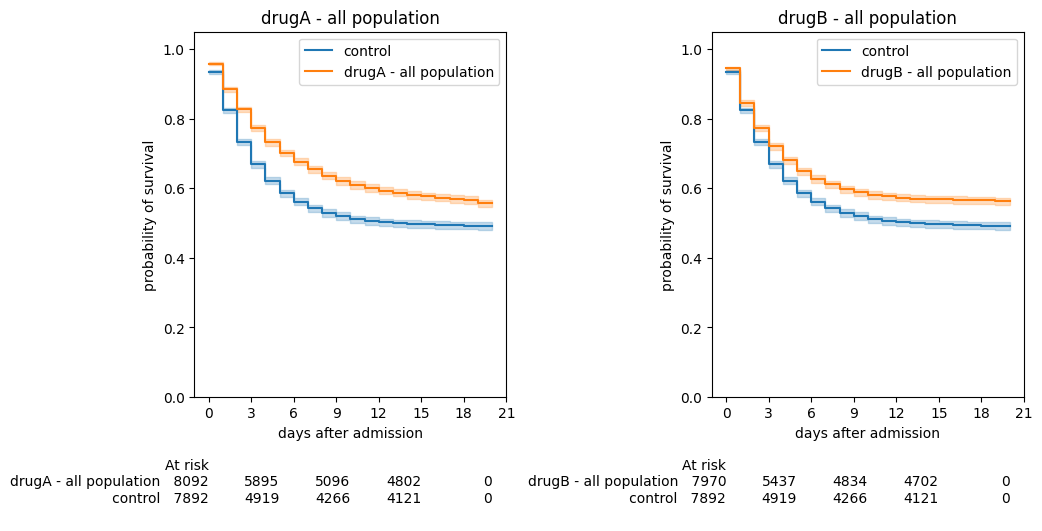

In [43]:
plot_primary_kaplan(df_person_fix, [(df_visit_epidemic, df_med, 'all population')], t_end_of_study)

What do you observe ?

**Correction** :  
We observe that both drug A and drug B improve significantly the chance of survival when considering the total population. The study conducted on real world data consequently confirms the conclusion of the randomized controlled trials. We can moreover see that, although the survival rate at 20 days after admission does not depend on the drug, patients treated with drug A feature a higher survival rate during the early days after admission.

The analysis presented in this notebook is obviously not representative of a real research study that usually comprises more data transformations and a more involved statistical design. In particular, we have not considered the biases that may be induced by discarding missing data although it is a crucial issue that may be addressed leveraging complex statistical methodologies. This notebook aims only at providing a first illustration of some challenges related to the analysis of Real-World Data provided in hospitals' clinical data warehouses. 

In particular, it shows that analysis pipelines suited to Real-World Data studies are complex and multistage. Consolidating the quality of preprocessing pipelines appears important to enhance the reliability of evidences produced on EHR data. This consolidation may be reached by opening the code of the analysis pipelines to review, and by developing and testing it collaboratively for instance as part of open source scientific libraries.

<a id="takeaways"></a>
# 4. Takeaways

- **Real-World Data verifies the no pain, no gain** principle. Although data may appear simpler to collect than in a randomized controlled trial, reaching meaningful insights requires correcting numerous biases and applying important transformations to raw data.
- **Administrative and claim data** comprises important information for research although its has not been collected for that purpose.
- **The analysis pipelines required to analyse Real-World Data are complex** and rely on numerous transformations that progressively improve data quality and its suitability for research. Sharing the development of analysis pipelines among projects, for instance in scientific libraries, improves the overall efficiency and quality of research.

<a id="references"></a>
# 5. References

- Kohane, Isaac S, Bruce J Aronow, Paul Avillach, Brett K Beaulieu-Jones, Riccardo Bellazzi, Robert L Bradford, Gabriel A Brat, et al. « What Every Reader Should Know About Studies Using Electronic Health Record Data but May Be Afraid to Ask ». Journal of Medical Internet Research 23, nᵒ 3 (2 mars 2021): e22219. https://doi.org/10.2196/22219.
- Kaplan, E. L., et Paul Meier. « Nonparametric Estimation from Incomplete Observations ». Journal of the American Statistical Association 53, nᵒ 282 (1958): 457‑81. https://doi.org/10.2307/2281868.
- Davidson-Pilon, Cameron. lifelines, survival analysis in Python. Zenodo, 2021. https://doi.org/10.5281/zenodo.5745573.
- McCoy, Allison B, Adam Wright, Michael G Kahn, Jason S Shapiro, Elmer Victor Bernstam, et Dean F Sittig. « Matching Identifiers in Electronic Health Records: Implications for Duplicate Records and Patient Safety ». BMJ Quality & Safety 22, nᵒ 3 (mars 2013): 219‑24. https://doi.org/10.1136/bmjqs-2012-001419.
- Wilson, Greg, D. A. Aruliah, C. Titus Brown, Neil P. Chue Hong, Matt Davis, Richard T. Guy, Steven H. D. Haddock, et al. « Best Practices for Scientific Computing ». Édité par Jonathan A. Eisen. PLoS Biology 12, nᵒ 1 (7 janvier 2014): e1001745. https://doi.org/10.1371/journal.pbio.1001745.